In [3]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import geopandas as gpd

# Tree Equity Score

In [4]:
# Load census data from get census data step

In [62]:
census_data = pd.read_csv("output/DA_Calgary_census_data.csv")
census_data.columns

Index(['REF_AREA', 'Total_age_0_4', 'Visible_Minority_Total',
       'Visible_Minority', 'Unemployment_rate', 'Total_age_65_older',
       'Total_LIM_18_64', 'Total_LIM_65_over', 'LIM_18_64', 'LIM_65_over',
       'Language_Total', 'Language_NO_Eng_Fr', 'Total_age'],
      dtype='object')

## Calculate Priority Measures

In [63]:
census_data["age"] = (
    census_data["Total_age_0_4"] + census_data["Total_age_65_older"]
) / census_data["Total_age"]
census_data["visible_minority"] = (
    census_data["Visible_Minority"] / census_data["Visible_Minority_Total"]
)
census_data["language"] = (
    census_data["Language_NO_Eng_Fr"] / census_data["Language_Total"]
)
census_data["low_income"] = (census_data["LIM_18_64"] + census_data["LIM_65_over"]) / (
    census_data["Total_LIM_18_64"] + census_data["Total_LIM_65_over"]
)
census_data["unemployed"] = census_data["Unemployment_rate"] / 100

In [64]:
selected_columns = [
    "REF_AREA",
    "age",
    "visible_minority",
    "language",
    "low_income",
    "unemployed",
]

In [65]:
df = census_data[selected_columns]
df = df.dropna()
df.head()

,REF_AREA,age,visible_minority,language,low_income,unemployed
0,2021S051248060056,0.193548,0.552083,0.053763,0.051282,0.164
1,2021S051248060057,0.200000,0.397436,0.066667,0.076923,0.067
2,2021S051248060058,0.247312,0.536842,0.074468,0.088608,0.061
3,2021S051248060059,0.314286,0.454545,0.042857,0.049180,0.059
4,2021S051248060060,0.300813,0.543307,0.089431,0.066038,0.176


## Join Canopy Cover Data

In [66]:
canopy_data = gpd.read_file("output/canopy_2020_da.json").rename(
    columns={"frac": "2020"}
)
canopy_data.head()

,2020,DGUID,geometry
0,0.114208,2021S051248060056,"POLYGON ((-114.09955 51.13959, -114.09861 51.1..."
1,0.088751,2021S051248060057,"POLYGON ((-114.09217 51.14023, -114.09212 51.1..."
2,0.119542,2021S051248060058,"POLYGON ((-114.099 51.13653, -114.09848 51.136..."
3,0.121823,2021S051248060059,"POLYGON ((-114.08938 51.14036, -114.08839 51.1..."
4,0.094170,2021S051248060060,"POLYGON ((-114.08898 51.14127, -114.08814 51.1..."


In [67]:
df = canopy_data.merge(df, left_on="DGUID", right_on="REF_AREA").drop(
    ["REF_AREA"], axis=1
)

In [68]:
## Join land surface temp

In [69]:
lst = gpd.read_file("output/lst.json")

In [70]:
df = df.merge(lst, on="DGUID").drop(["geometry_x", "avg_lst", "lst"], axis=1)
df = df.rename(columns={"geometry_y": "geometry"})
df = df.set_geometry("geometry")

In [71]:
df.head()

,2020,DGUID,age,visible_minority,language,low_income,unemployed,temp_diff,geometry
0,0.114208,2021S051248060056,0.193548,0.552083,0.053763,0.051282,0.164,4.034653,"POLYGON ((283181.659 5669916.204, 283245.036 5..."
1,0.088751,2021S051248060057,0.200000,0.397436,0.066667,0.076923,0.067,3.931484,"POLYGON ((283700.486 5669966.112, 283702.041 5..."
2,0.119542,2021S051248060058,0.247312,0.536842,0.074468,0.088608,0.061,1.546526,"POLYGON ((283205.945 5669575.068, 283242.725 5..."
3,0.121823,2021S051248060059,0.314286,0.454545,0.042857,0.049180,0.059,2.344821,"POLYGON ((283896.638 5669972.142, 283963.332 5..."
4,0.094170,2021S051248060060,0.300813,0.543307,0.089431,0.066038,0.176,0.968386,"POLYGON ((283928.717 5670072.441, 283985.85 56..."


## Difference between Canopy Goal (16%)

In [72]:
df["canopy_diff"] = (0.16 - df["2020"]).clip(lower=0)

## Normalize Priority Indicators

In [73]:
priority_columns = [
    "age",
    "visible_minority",
    "language",
    "low_income",
    "unemployed",
    "temp_diff",
]

priority_columns_norm = [
    "age_norm",
    "visible_minority_norm",
    "language_norm",
    "low_income_norm",
    "unemployed_norm",
    "temp_diff_norm",
]

In [74]:
scaler = MinMaxScaler()
df[priority_columns_norm] = scaler.fit_transform(df[priority_columns])

In [75]:
df.head()

,2020,DGUID,age,visible_minority,language,low_income,unemployed,temp_diff,geometry,canopy_diff,age_norm,visible_minority_norm,language_norm,low_income_norm,unemployed_norm,temp_diff_norm
0,0.114208,2021S051248060056,0.193548,0.552083,0.053763,0.051282,0.164,4.034653,"POLYGON ((283181.659 5669916.204, 283245.036 5...",0.045792,0.250499,0.555004,0.125154,0.073942,0.369369,0.737696
1,0.088751,2021S051248060057,0.200000,0.397436,0.066667,0.076923,0.067,3.931484,"POLYGON ((283700.486 5669966.112, 283702.041 5...",0.071249,0.260988,0.399539,0.155191,0.110912,0.150901,0.732167
2,0.119542,2021S051248060058,0.247312,0.536842,0.074468,0.088608,0.061,1.546526,"POLYGON ((283205.945 5669575.068, 283242.725 5...",0.040458,0.337909,0.539683,0.173352,0.127760,0.137387,0.604338
3,0.121823,2021S051248060059,0.314286,0.454545,0.042857,0.049180,0.059,2.344821,"POLYGON ((283896.638 5669972.142, 283963.332 5...",0.038177,0.446797,0.456950,0.099766,0.070911,0.132883,0.647125
4,0.094170,2021S051248060060,0.300813,0.543307,0.089431,0.066038,0.176,0.968386,"POLYGON ((283928.717 5670072.441, 283985.85 56...",0.065830,0.424892,0.546182,0.208183,0.095217,0.396396,0.573352


## Calculate Tree Equity Score

In [76]:
def priority_index(x):
    return 0.1 + (1 - 0.1) * (
        (
            x["age_norm"]
            + x["visible_minority_norm"]
            + x["language_norm"]
            + x["low_income_norm"]
            + x["unemployed_norm"]
            + x["temp_diff_norm"]
        )
        / 5
    )

In [77]:
df["priority"] = df.apply(priority_index, axis=1)

In [78]:
df["canopy_score"] = df["canopy_diff"] / df["canopy_diff"].max()

In [79]:
def equity_index(x):
    return (1 - (x["canopy_score"] * x["priority"])) * 100

In [80]:
df["index"] = df.apply(equity_index, axis=1)

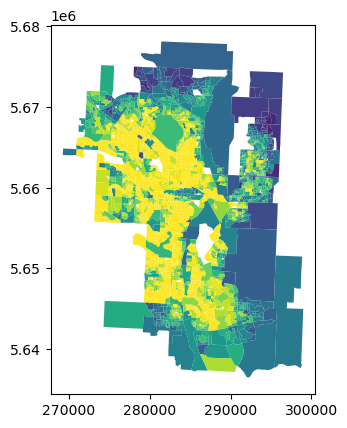

In [81]:
df.plot(column="index");

In [82]:
final_index = df[["geometry", "DGUID", "priority", "index", "2020"] + priority_columns]
final_index.head()

,geometry,DGUID,priority,index,2020,age,visible_minority,language,low_income,unemployed,temp_diff
0,"POLYGON ((283181.659 5669916.204, 283245.036 5...",2021S051248060056,0.480100,85.955955,0.114208,0.193548,0.552083,0.053763,0.051282,0.164,4.034653
1,"POLYGON ((283700.486 5669966.112, 283702.041 5...",2021S051248060057,0.425746,80.622417,0.088751,0.200000,0.397436,0.066667,0.076923,0.067,3.931484
2,"POLYGON ((283205.945 5669575.068, 283242.725 5...",2021S051248060058,0.445677,88.481485,0.119542,0.247312,0.536842,0.074468,0.088608,0.061,1.546526
3,"POLYGON ((283896.638 5669972.142, 283963.332 5...",2021S051248060059,0.433798,89.420434,0.121823,0.314286,0.454545,0.042857,0.049180,0.059,2.344821
4,"POLYGON ((283928.717 5670072.441, 283985.85 56...",2021S051248060060,0.503960,78.807029,0.094170,0.300813,0.543307,0.089431,0.066038,0.176,0.968386


In [83]:
final_index.to_file("output/equity_index_da.geojson", driver="GeoJSON")